<a href="https://colab.research.google.com/github/BVika/Machine_learning_methods/blob/main/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B0_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# МЛ практика 7. Финализация умений

## **Цель занятия:**
Изучить задачу снижения размерности, познакомиться с более продвинутыми метриками качества, изучение объекта Pipeline из scikit-learn, поиск лучших метрик.

## **Задание состоит из следующих частей:**
1. Объект Pipeline
2. Метрики качества для решения задач классификации, регрессии
3. Снижение размерности
4. Поиск лучших метрик качества (GridSearch)


## Домашка ⏰

1. Заюзать пайплайны для своиз данных
2. Сделать 2D,3D PCA (T-SNE). Визуалзиация + классификация/регрессия
3. Найти лучшую модель через GridSearch (задача на выбор или обе)
4. Сделать оценку с новыми метриками

Для 👽
1. Использовать Catboost для классификации и регресси (https://catboost.ai/)
2. Вместо T-SNE использовать UMAP (https://umap-learn.readthedocs.io/en/latest/).
3. Найти датасет с картинками и попробовать классфицировать его (в идеале должны быть картинки и файлик с классами). Если не найдете, то можно сделать кластеризацию и предсказывать кластеры
4. Объяснитьк как работает Catboost

In [46]:
!pip install pandas scikit-learn seaborn scipy catboost umap-learn

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Загрузка набора данных
df = pd.read_csv('/content/heart.csv')
df['risk_group']= np.where(df['IHD_DX']<=5, 1, 0)
df.risk_group = df.risk_group.astype('category')
df = df.drop('IHD_DX', axis=1)

df.DEATH = df.DEATH.astype('category')

In [24]:
df

,AGE_50,MD_50,SBP_50,DBP_50,HT_50,WT_50,CHOL_50,SES,CL_STATUS,MD_62,SBP_62,DBP_62,CHOL_62,WT_62,DEATH,risk_group
0,42,1,110,65,64,147,291,2,8,4,120,78,271,146,1,1
1,53,1,130,72,69,167,278,1,6,2,122,68,250,165,1,0
2,53,2,120,90,70,222,342,4,8,1,132,90,304,223,1,1
3,48,4,120,80,72,229,239,4,8,2,118,68,209,227,1,1
4,53,3,118,74,66,134,243,3,8,5,118,56,261,138,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,50,1,115,80,66,148,300,2,8,1,115,65,273,152,0,1
196,23,1,110,70,69,137,120,3,8,2,112,76,198,153,0,1
197,20,3,130,80,66,150,210,5,0,1,130,85,274,158,0,1
198,46,3,140,84,66,138,130,4,6,2,148,88,160,157,0,1


In [48]:
y_regression = df['CHOL_50'] # числая переменная как y
X_regression = df.copy().drop('CHOL_50', axis=1).reindex() # переменные для проверки влияния

y_classification = df['risk_group'] # категориальная переменная как y
X_classification = df.copy().drop('risk_group', axis=1).reindex() # переменные для проверки влияния

In [49]:
X_regression.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   AGE_50      200 non-null    int64   
 1   MD_50       200 non-null    int64   
 2   SBP_50      200 non-null    int64   
 3   DBP_50      200 non-null    int64   
 4   HT_50       200 non-null    int64   
 5   WT_50       200 non-null    int64   
 6   SES         200 non-null    int64   
 7   CL_STATUS   200 non-null    int64   
 8   MD_62       200 non-null    int64   
 9   SBP_62      200 non-null    int64   
 10  DBP_62      200 non-null    int64   
 11  CHOL_62     200 non-null    int64   
 12  WT_62       200 non-null    int64   
 13  DEATH       200 non-null    category
 14  risk_group  200 non-null    category
dtypes: category(2), int64(13)
memory usage: 21.1 KB


## Pipeline

#### **Что такое ColumnTransformer?**
**ColumnTransformer** — это объект в `scikit-learn`, который позволяет применять разные трансформации к разным группам признаков (столбцов) в одном шаге.

- **Пример кода:**
  ```python
  from sklearn.compose import ColumnTransformer
  from sklearn.preprocessing import StandardScaler, OneHotEncoder

  preprocessor = ColumnTransformer([
      ('num', StandardScaler(), numeric_columns),
      ('cat', OneHotEncoder(), categorical_columns)
  ])


#### **Что такое Pipeline?**
**Pipeline** — это объект в `scikit-learn`, который объединяет последовательность шагов обработки данных и обучения модели в единый процесс. Каждый шаг выполняется последовательно, начиная с предобработки данных и заканчивая обучением модели.

1. Каждый шаг состоит из имени и объекта (`'step_name', transformer_or_model`).
2. Все шаги, кроме последнего, должны быть трансформаторами (иметь методы `fit` и `transform`).
3. Последний шаг — это модель с методами `fit` и `predict`.

---

### **Пример использования Pipeline**

```python
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

# Создание пайплайна
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Масштабирование данных
    ('classifier', RandomForestClassifier(random_state=42))  # Обучение модели
])

# Обучение модели
pipeline.fit(X_train, y_train)

# Предсказания
y_pred = pipeline.predict(X_test)


In [50]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [51]:
# Выделение числовых и категориальных колонок
numerical_features_regression = X_regression.select_dtypes(include=['float64', 'int64']).columns
categorical_features_regression = X_regression.select_dtypes(include=['category']).columns

numerical_features_classification = X_classification.select_dtypes(include=['float64', 'int64']).columns
categorical_features_classification = X_classification.select_dtypes(include=['category']).columns

# Создание трансформеров
preprocessor_regression = ColumnTransformer(
  [
    ('num', StandardScaler(), numerical_features_regression),
    ('cat', OneHotEncoder(), categorical_features_regression),
  ],
  verbose=True
)

preprocessor_classification = ColumnTransformer(
  [
    ('num', StandardScaler(), numerical_features_classification),
    ('cat', OneHotEncoder(), categorical_features_classification)
  ],
  verbose=True
)

### Для регрессии

In [52]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np
from catboost import CatBoostRegressor

# Разделение данных
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_regression, y_regression, test_size=0.2, random_state=42
)
# Пайплайн для регрессии
regression_pipeline = Pipeline([
    ('preprocessor', preprocessor_regression),  # Включает StandardScaler и OneHotEncoder
    ('regressor', CatBoostRegressor(verbose=0, random_state=42))          # Модель
], verbose=True)

# Обучение модели
regression_pipeline.fit(X_train_reg, y_train_reg)

# Предсказания
y_pred_reg = regression_pipeline.predict(X_test_reg)

# Метрики для регрессии
mse = mean_squared_error(y_test_reg, y_pred_reg)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test_reg, y_pred_reg)

print(f"\nСреднеквадратичная ошибка (MSE): {mse:.4f}")
print(f"Корень из MSE (RMSE): {rmse:.4f}")
print(f"Средний абсолютный процент ошибки (MAPE): {mape:.4f}, то есть {mape * 100:.4f}%")


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   4.6s

Среднеквадратичная ошибка (MSE): 3685.2263
Корень из MSE (RMSE): 60.7061
Средний абсолютный процент ошибки (MAPE): 0.1445, то есть 14.4489%


Среднеквадратичная ошибка (MSE):

Значение: 3685.2263
Объяснение: MSE измеряет среднее значение квадратов ошибок, то есть разностей между предсказанными и фактическими значениями. Чем ниже значение MSE, тем лучше модель, так как это означает, что предсказания модели ближе к фактическим значениям. Значение 3685.2263 указывает на то, что в среднем квадрат ошибки достаточно велик, что может свидетельствовать о том, что модель не идеально предсказывает целевую переменную.
Корень из MSE (RMSE):

Значение: 60.7061
Объяснение: RMSE является квадратным корнем из MSE и возвращает значение в тех же единицах, что и целевая переменная. Это делает RMSE более интерпретируемым, так как позволяет легко понять, насколько в среднем ошибаются предсказания модели. Значение 60.7061 говорит о том, что в среднем предсказания модели отклоняются от фактических значений на примерно 60.71 единиц.
Средний абсолютный процент ошибки (MAPE):

Значение: 0.1445, или 14.4489%
Объяснение: MAPE измеряет среднюю абсолютную процентную ошибку между предсказанными и фактическими значениями. Это выражается в процентах, что делает его особенно удобным для интерпретации. Значение 14.4489% указывает на то, что в среднем предсказания модели отклоняются от фактических значений на 14.45%. Это может быть полезным для оценки производительности модели в контексте бизнес-задач, где процентные ошибки могут быть более интуитивно понятными.

#### Пару слов о новых метриках

**RMSE: Корень из среднеквадратичной ошибки (Root Mean Squared Error)**

**RMSE** — это метрика, которая измеряет среднее отклонение предсказанных значений от фактических в квадрате, а затем возвращает квадратный корень результата. Это позволяет интерпретировать ошибки в тех же единицах измерения, что и целевая переменная \( y \).

##### **Как работает RMSE?**
1. Вычисляет разницу между предсказанными и фактическими значениями.
2. Возводит каждую разницу в квадрат (чтобы ошибки не сокращались за счет их знака).
3. Находит среднее значение квадратов ошибок.
4. Берет квадратный корень, чтобы вернуть метрику в исходные единицы.

##### **Особенности RMSE:**
- **Чувствительность к большим ошибкам**: RMSE сильнее наказывает крупные отклонения, чем, например, MAE.
- Хорошо подходит для задач, где важны большие ошибки, и нужно их минимизировать.

##### **Пример интерпретации:**
Если RMSE равно 5, это означает, что в среднем предсказания модели отклоняются от фактических значений на **5 единиц**.

---

##### **MAPE: Средний абсолютный процент ошибки (Mean Absolute Percentage Error)**

**MAPE** — это метрика, которая измеряет среднюю ошибку предсказаний в процентах относительно фактических значений. Она показывает, на сколько процентов в среднем модель ошибается в предсказаниях.

##### **Как работает MAPE?**
1. Вычисляет абсолютную разницу между предсказанными и фактическими значениями.
2. Делит каждую ошибку на фактическое значение.
3. Берет среднее значение этих долей и умножает на 100, чтобы выразить в процентах.

##### **Особенности MAPE:**
- Легко интерпретируется: "Наша модель ошибается в среднем на X%".
- Не учитывает направление ошибки (переоценка или недооценка).
- Чувствительна к малым значениям целевой переменной: если истинное значение близко к нулю, MAPE может стать крайне высокой.

##### **Пример интерпретации:**
Если MAPE равно \( 10 \%\), это означает, что модель в среднем ошибается на **10%** от фактического значения.


### Тоже самое для классификации

In [53]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss
from catboost import CatBoostClassifier

# Разделение данных
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_classification, y_classification, test_size=0.2, random_state=42
)

catboost_model = CatBoostClassifier(iterations=100, depth=6, learning_rate=0.1, verbose=0)



# Пайплайн для классификации
classification_pipeline = Pipeline([
    ('preprocessor', preprocessor_classification),  # Включает StandardScaler и OneHotEncoder
    ('classifier', catboost_model)
], verbose=True)

# Обучение модели
classification_pipeline.fit(X_train_clf, y_train_clf)

# Предсказания
y_pred_clf = classification_pipeline.predict(X_test_clf)
y_pred_proba_clf = classification_pipeline.predict_proba(X_test_clf)

# Метрики для классификации
accuracy = accuracy_score(y_test_clf, y_pred_clf)
precision = precision_score(y_test_clf, y_pred_clf, average='weighted')
recall = recall_score(y_test_clf, y_pred_clf, average='weighted')
f1 = f1_score(y_test_clf, y_pred_clf, average='weighted')
# auc = roc_auc_score(y_test_clf, y_pred_proba_clf, multi_class='ovr', average='weighted') #накрылось что-то
logloss = log_loss(y_test_clf, y_pred_proba_clf)

print(f"Точность (accuracy): {accuracy:.4f}")
print(f"Точность (precision): {precision:.4f}")
print(f"Полнота (recall): {recall:.4f}")
print(f"F1-мера: {f1:.4f}")
# print(f"AUC: {auc:.4f}")
print(f"Логарифмическая потеря (log-loss): {logloss:.4f}")

[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.1s
Точность (accuracy): 0.9000
Точность (precision): 0.8100
Полнота (recall): 0.9000
F1-мера: 0.8526
Логарифмическая потеря (log-loss): 0.3178


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Точность (Accuracy):

Значение: 0.9000 (или 90%)
Объяснение: Это доля правильно классифицированных образцов к общему количеству образцов. В данном случае, 90% всех предсказаний модели были верными. Точность — это простая и интуитивно понятная метрика, однако она может быть неэффективной в случае несбалансированных классов.
Точность (Precision):

Значение: 0.8100 (или 81%)
Объяснение: Это доля истинно положительных предсказаний к общему числу положительных предсказаний (истинно положительные + ложно положительные). В данном случае, из всех предсказанных положительных классов (например, класс "1"), 81% действительно оказались положительными. Высокая точность означает, что модель делает мало ложных положительных предсказаний.
Полнота (Recall):

Значение: 0.9000 (или 90%)
Объяснение: Это доля истинно положительных предсказаний к общему числу фактических положительных образцов (истинно положительные + ложно отрицательные). В данном случае, модель правильно идентифицировала 90% всех положительных образцов. Высокая полнота говорит о том, что модель хорошо находит все положительные примеры, но может пропускать некоторые из них.
F1-мера:

Значение: 0.8526 (или 85.26%)
Объяснение: Это среднее гармоническое между точностью и полнотой. F1-мера используется, когда важно учитывать как точность, так и полноту, особенно в случаях несбалансированных классов. Значение 0.8526 указывает на то, что модель имеет хорошее соотношение между точностью и полнотой.
Логарифмическая потеря (Log-loss):

Значение: 0.3178
Объяснение: Логарифмическая потеря измеряет, насколько хорошо предсказанные вероятности соответствуют фактическим меткам классов. Чем ниже значение логарифмической потери, тем лучше модель. Значение 0.3178 указывает на то, что модель делает разумные предсказания, но есть место для улучшения.

#### Пару слов о новой метрике

Если log-loss равен **14.6115**, это указывает на то, что модель предсказывает вероятности с большими ошибками. Чем выше log-loss, тем хуже модель справляется с прогнозированием вероятностей.

##### **Интерпретация log-loss:**
- **Низкое значение log-loss:** модель хорошо калибрована, предсказанные вероятности близки к истинным значениям (например, высокая вероятность для правильного класса).
- **Высокое значение log-loss (как 14.6115):** вероятности модели не соответствуют истинным классам, либо она делает "уверенные" ошибки, назначая высоким вероятностям неправильные классы.

##### **Что делать при высоком log-loss?**
1. **Улучшить модель:**
   - Использовать более сложные алгоритмы.
   - Настроить гиперпараметры.
2. **Улучшить данные:**
   - Удалить шум.
   - Проверить сбалансированность классов.
3. **Калибровка вероятностей:**
   - Методы вроде Platt Scaling или Isotonic Regression помогают лучше калибровать вероятности.

Log-loss в значении 14.6115 — это знак, что модель требует значительных улучшений.

## Снижение размерности

#### **Что такое снижение размерности?**
Снижение размерности — это процесс преобразования данных с большим количеством признаков (столбцов) в набор меньшего размера, сохраняя при этом как можно больше важной информации. Это особенно полезно, когда данные имеют высокую размерность, что может приводить к:

1. **Избыточной информации:** Некоторые признаки могут быть сильно коррелированы или не нести полезной информации.
2. **Проклятию размерности:** Чем больше признаков, тем сложнее моделям найти закономерности.
3. **Высокой вычислительной сложности:** Больше признаков — больше времени и ресурсов на обработку.

---

#### **Для чего нужно снижение размерности?**
- **Улучшение производительности моделей:** Удаление лишних признаков уменьшает шум и делает данные более управляемыми.
- **Ускорение работы:** Меньшее число признаков ускоряет обучение моделей.
- **Визуализация:** Легче визуализировать данные, если они сокращены до 2D или 3D.
- **Понимание данных:** Снижая размерность, мы можем увидеть основные направления вариации в данных.

---

### **PCA: Главные компоненты (Principal Component Analysis)**

#### **Что это?**
PCA (Анализ главных компонент) — это метод снижения размерности, который ищет новые признаки (главные компоненты), максимизирующие объясненную дисперсию данных. Эти компоненты — это линейные комбинации исходных признаков.

#### **Как работает PCA?**
1. Вычисляет дисперсию данных и находит направления (оси), вдоль которых данные изменяются максимально.
2. Создает новые признаки — главные компоненты.
3. Упорядочивает компоненты по убыванию их важности (объясненной дисперсии).
4. Оставляет только несколько самых важных компонентов.

#### **Когда использовать PCA?**
- Когда нужно сократить количество признаков перед обучением модели.
- Когда признаки сильно коррелированы.
- Для ускорения работы моделей.

---

### **t-SNE: Визуализация соседей (t-distributed Stochastic Neighbor Embedding)**

#### **Что это?**
t-SNE — это метод, предназначенный для визуализации данных. Он переводит высокоразмерные данные в 2D или 3D, сохраняя близость между точками. Это помогает увидеть скрытые структуры в данных.

#### **Как работает t-SNE?**
1. Вычисляет, какие точки в многомерном пространстве являются "соседями".
2. Строит новую, низкоразмерную карту данных, стараясь сохранить те же отношения между точками.

#### **Особенности t-SNE:**
- **Фокус на локальной структуре:** Лучше всего показывает кластеры данных.
- **Визуализация сложных данных:** Например, для наборов с тысячами признаков.

#### **Когда использовать t-SNE?**
- Для визуализации сложных наборов данных (например, изображения, тексты).
- Чтобы понять, как объекты сгруппированы в пространстве.

---

### **Сравнение PCA и t-SNE**
| **Критерий**         | **PCA**                              | **t-SNE**                           |
|-----------------------|---------------------------------------|--------------------------------------|
| **Цель**             | Уменьшение размерности               | Визуализация данных                 |
| **Тип структуры**    | Сохраняет глобальную структуру       | Сохраняет локальную структуру       |
| **Скорость**         | Быстрее                              | Медленнее                           |
| **Применение**       | Для предобработки перед моделированием | Для анализа и визуализации          |

---

### **Итог**
- Используйте **PCA**, если хотите уменьшить размер данных для обучения модели.
- Используйте **t-SNE**, если хотите визуализировать сложные данные и понять их структуру.

### Пример использования

Попробуем визуализировать признаки в 2D и 3D пространстве алгоритмами PCA и T-SNE

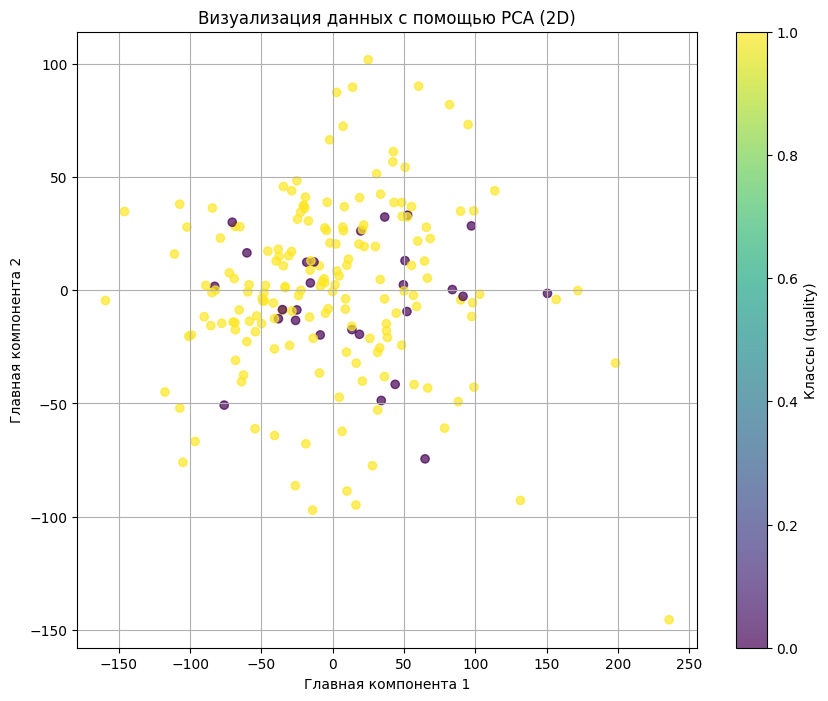

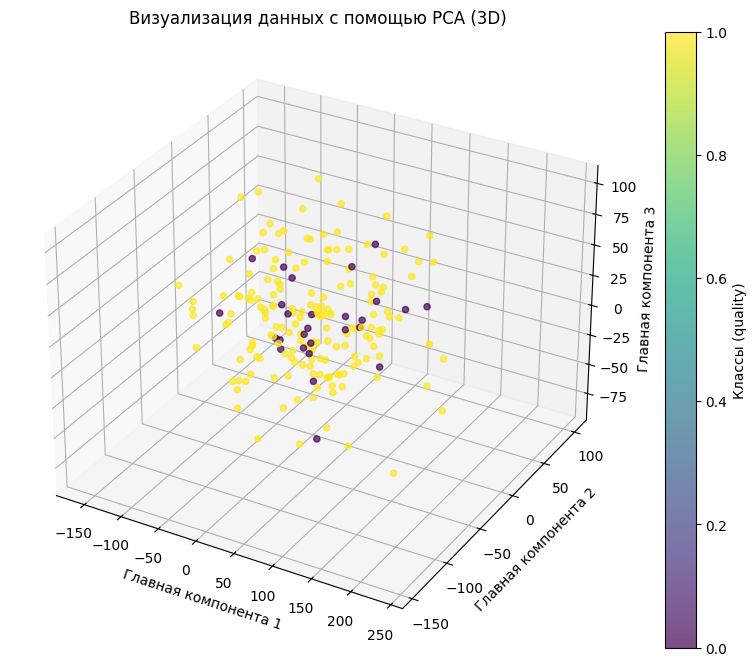

Точность классификации с PCA (2D): 0.8750
Точность классификации с PCA (3D): 0.9000


In [54]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from mpl_toolkits.mplot3d import Axes3D

# Преобразование данных с помощью PCA
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_classification.select_dtypes(include=['float64', 'int64']))

pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_classification.select_dtypes(include=['float64', 'int64']))

# 2D визуализация PCA
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=y_classification, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Классы (quality)')
plt.title("Визуализация данных с помощью PCA (2D)")
plt.xlabel("Главная компонента 1")
plt.ylabel("Главная компонента 2")
plt.grid(True)
plt.show()

# 3D визуализация PCA
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], c=y_classification, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Классы (quality)')
ax.set_title("Визуализация данных с помощью PCA (3D)")
ax.set_xlabel("Главная компонента 1")
ax.set_ylabel("Главная компонента 2")
ax.set_zlabel("Главная компонента 3")
plt.show()

# Классификация PCA (2D и 3D)
# Разделение данных
X_train_2d, X_test_2d, y_train, y_test = train_test_split(X_pca_2d, y_classification, test_size=0.2, random_state=42)
X_train_3d, X_test_3d = train_test_split(X_pca_3d, test_size=0.2, random_state=42)

# Модель
clf = RandomForestClassifier(random_state=42)

# Обучение на 2D данных
clf.fit(X_train_2d, y_train)
y_pred_2d = clf.predict(X_test_2d)
accuracy_2d = accuracy_score(y_test, y_pred_2d)
print(f"Точность классификации с PCA (2D): {accuracy_2d:.4f}")

# Обучение на 3D данных
clf.fit(X_train_3d, y_train)
y_pred_3d = clf.predict(X_test_3d)
accuracy_3d = accuracy_score(y_test, y_pred_3d)
print(f"Точность классификации с PCA (3D): {accuracy_3d:.4f}")


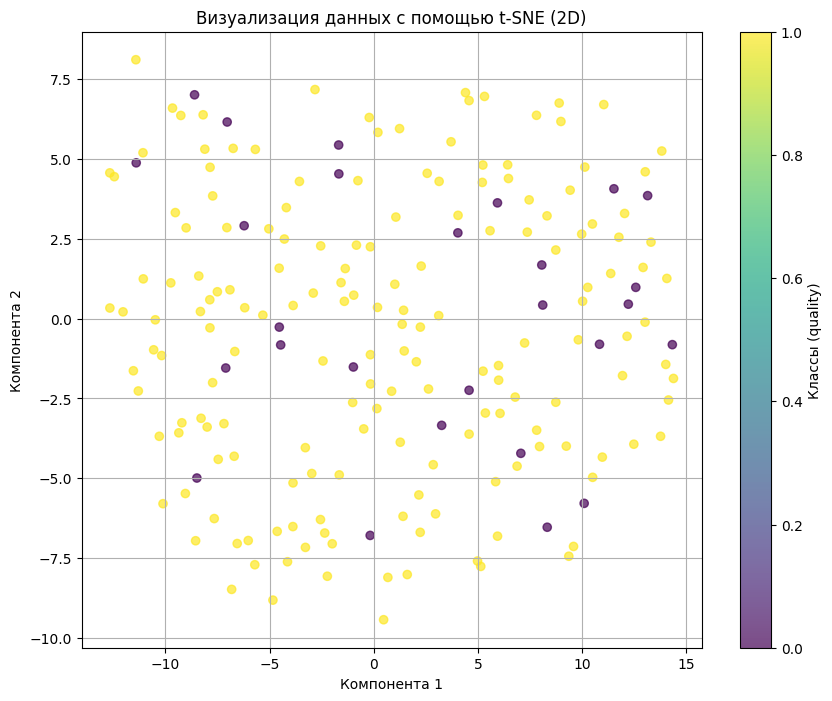

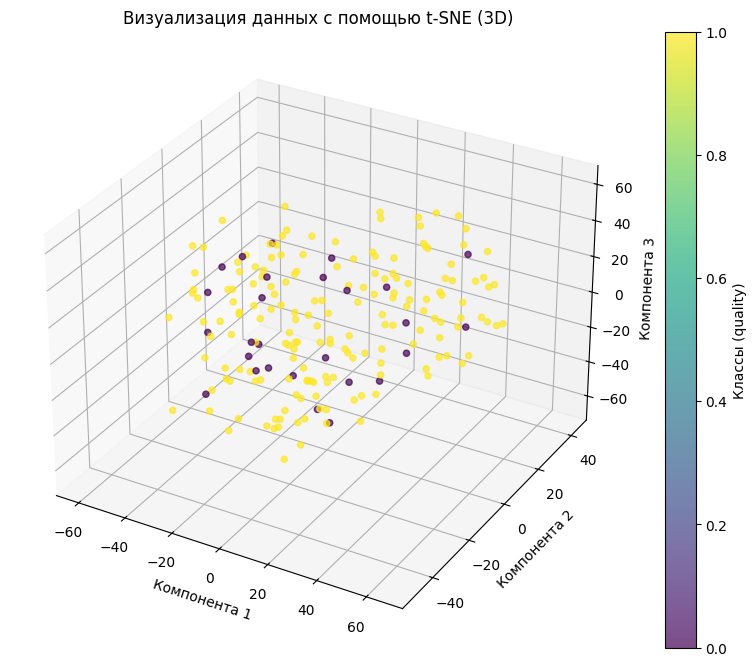

Точность классификации с t-SNE (2D): 0.9250
Точность классификации с t-SNE (3D): 0.8750


In [55]:
from sklearn.manifold import TSNE

# Преобразование данных с помощью t-SNE
tsne_2d = TSNE(n_components=2, random_state=42)
X_tsne_2d = tsne_2d.fit_transform(X_classification.select_dtypes(include=['float64', 'int64']))

tsne_3d = TSNE(n_components=3, random_state=42)
X_tsne_3d = tsne_3d.fit_transform(X_classification.select_dtypes(include=['float64', 'int64']))

# 2D визуализация t-SNE
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tsne_2d[:, 0], X_tsne_2d[:, 1], c=y_classification, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Классы (quality)')
plt.title("Визуализация данных с помощью t-SNE (2D)")
plt.xlabel("Компонента 1")
plt.ylabel("Компонента 2")
plt.grid(True)
plt.show()

# 3D визуализация t-SNE
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_tsne_3d[:, 0], X_tsne_3d[:, 1], X_tsne_3d[:, 2], c=y_classification, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Классы (quality)')
ax.set_title("Визуализация данных с помощью t-SNE (3D)")
ax.set_xlabel("Компонента 1")
ax.set_ylabel("Компонента 2")
ax.set_zlabel("Компонента 3")
plt.show()

# Классификация t-SNE (2D и 3D)
# Разделение данных
X_train_2d, X_test_2d, y_train, y_test = train_test_split(X_tsne_2d, y_classification, test_size=0.2, random_state=42)
X_train_3d, X_test_3d = train_test_split(X_tsne_3d, test_size=0.2, random_state=42)

# Модель
clf = RandomForestClassifier(random_state=42)

# Обучение на 2D данных
clf.fit(X_train_2d, y_train)
y_pred_2d = clf.predict(X_test_2d)
accuracy_2d = accuracy_score(y_test, y_pred_2d)
print(f"Точность классификации с t-SNE (2D): {accuracy_2d:.4f}")

# Обучение на 3D данных
clf.fit(X_train_3d, y_train)
y_pred_3d = clf.predict(X_test_3d)
accuracy_3d = accuracy_score(y_test, y_pred_3d)
print(f"Точность классификации с t-SNE (3D): {accuracy_3d:.4f}")


### UMAP

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


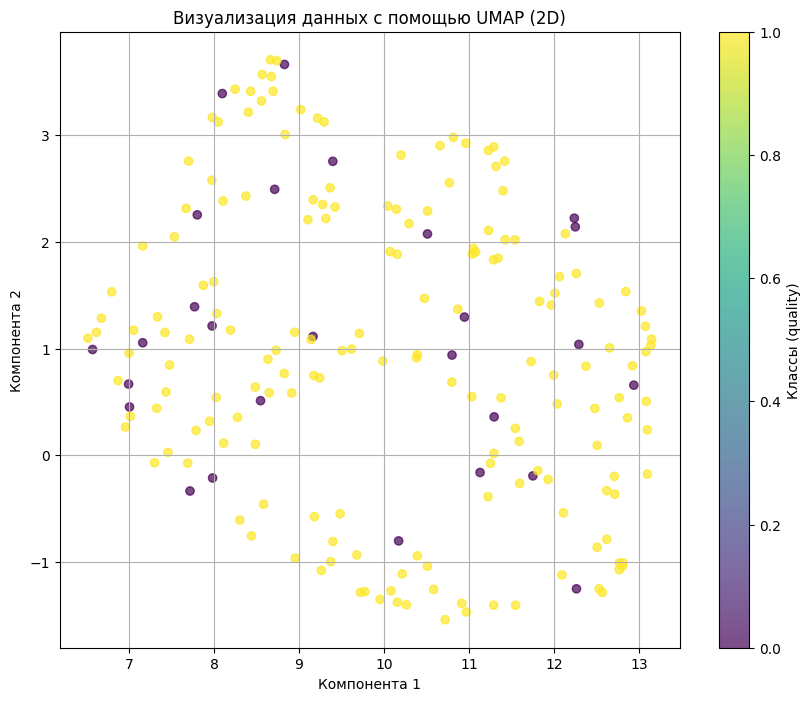

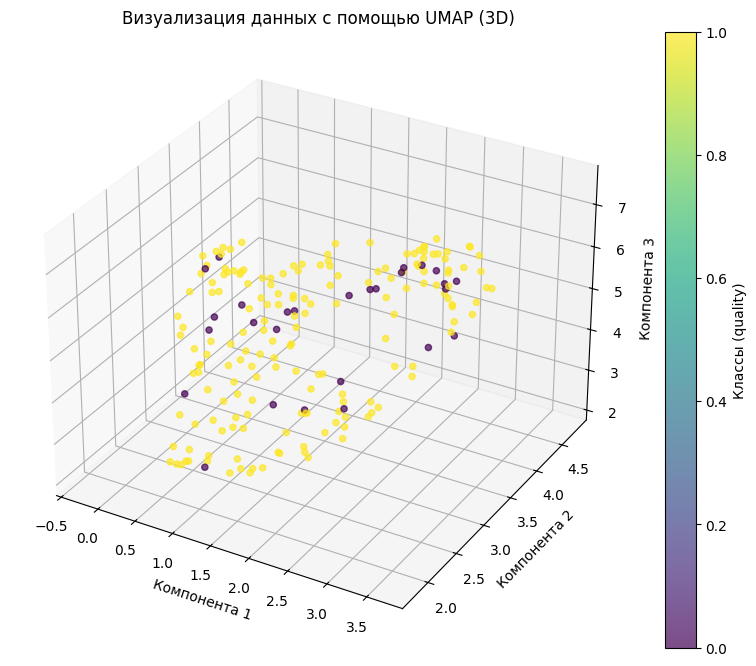

Точность классификации с UMAP (2D): 0.9250
Точность классификации с UMAP (3D): 0.9000


In [56]:
import umap

# Преобразование данных с помощью UMAP
umap_2d = umap.UMAP(n_components=2, random_state=42)
X_umap_2d = umap_2d.fit_transform(X_classification.select_dtypes(include=['float64', 'int64']))
umap_3d = umap.UMAP(n_components=3, random_state=42)
X_umap_3d = umap_3d.fit_transform(X_classification.select_dtypes(include=['float64', 'int64']))

# 2D визуализация UMAP
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_umap_2d[:, 0], X_umap_2d[:, 1], c=y_classification, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Классы (quality)')
plt.title("Визуализация данных с помощью UMAP (2D)")
plt.xlabel("Компонента 1")
plt.ylabel("Компонента 2")
plt.grid(True)
plt.show()

# 3D визуализация UMAP
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_umap_3d[:, 0], X_umap_3d[:, 1], X_umap_3d[:, 2], c=y_classification, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Классы (quality)')
ax.set_title("Визуализация данных с помощью UMAP (3D)")
ax.set_xlabel("Компонента 1")
ax.set_ylabel("Компонента 2")
ax.set_zlabel("Компонента 3")
plt.show()

# Классификация UMAP (2D и 3D)
# Разделение данных
X_train_2d, X_test_2d, y_train, y_test = train_test_split(X_umap_2d, y_classification, test_size=0.2, random_state=42)
X_train_3d, X_test_3d = train_test_split(X_umap_3d, test_size=0.2, random_state=42)

# Модель
clf = RandomForestClassifier(random_state=42)
# Обучение на 2D данных
clf.fit(X_train_2d, y_train)
y_pred_2d = clf.predict(X_test_2d)
accuracy_2d = accuracy_score(y_test, y_pred_2d)
print(f"Точность классификации с UMAP (2D): {accuracy_2d:.4f}")
# Обучение на 3D данных
clf.fit(X_train_3d, y_train)
y_pred_3d = clf.predict(X_test_3d)
accuracy_3d = accuracy_score(y_test, y_pred_3d)
print(f"Точность классификации с UMAP (3D): {accuracy_3d:.4f}")

### А как видна идеальная картинка ? (БОНУС)

In [31]:
from sklearn.datasets import load_digits

digest - датасет c "оттенками" серого визуализации чисел

In [32]:
# Загрузка данных
digits = load_digits()
X, y = digits.data, digits.target

# Фильтрация: только числа 1-9
mask = y != 0
X = X[mask]
y = y[mask]

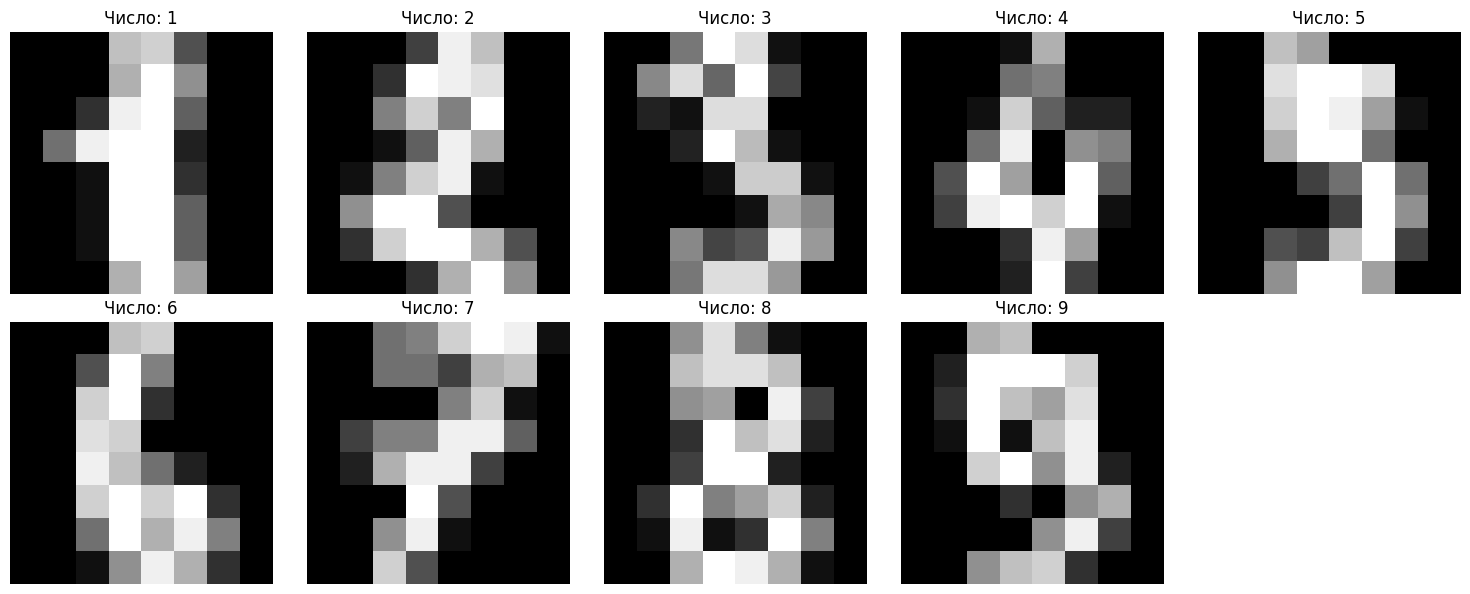

In [33]:
# Визуализация всех цифр 1-9
plt.figure(figsize=(15, 6))

unique_labels = list(range(1, 10))
for i, label in enumerate(unique_labels):
    # Найдем первое вхождение каждой цифры
    idx = (y == label).argmax()
    plt.subplot(2, 5, i + 1)
    plt.imshow(X[idx].reshape(8, 8), cmap='gray', interpolation='nearest')
    plt.title(f"Число: {label}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [34]:
y

array([1, 2, 3, ..., 8, 9, 8])

In [5]:
import matplotlib.pyplot as plt
from keras.datasets import mnist

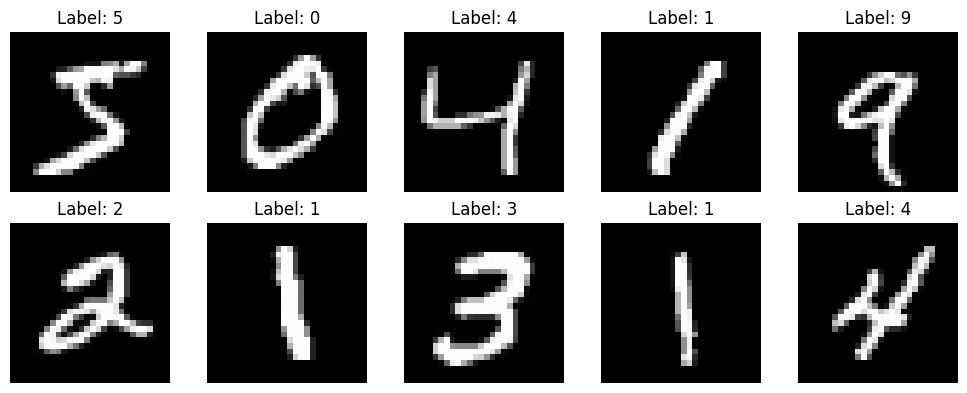

In [6]:
# Загрузка данных
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# Загрузка датасета MNIST
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Визуализация первых 10 изображений
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train[i], cmap='gray')
    plt.title(f'Label: {y_train[i]}')
    plt.axis('off')

plt.tight_layout()
plt.show()

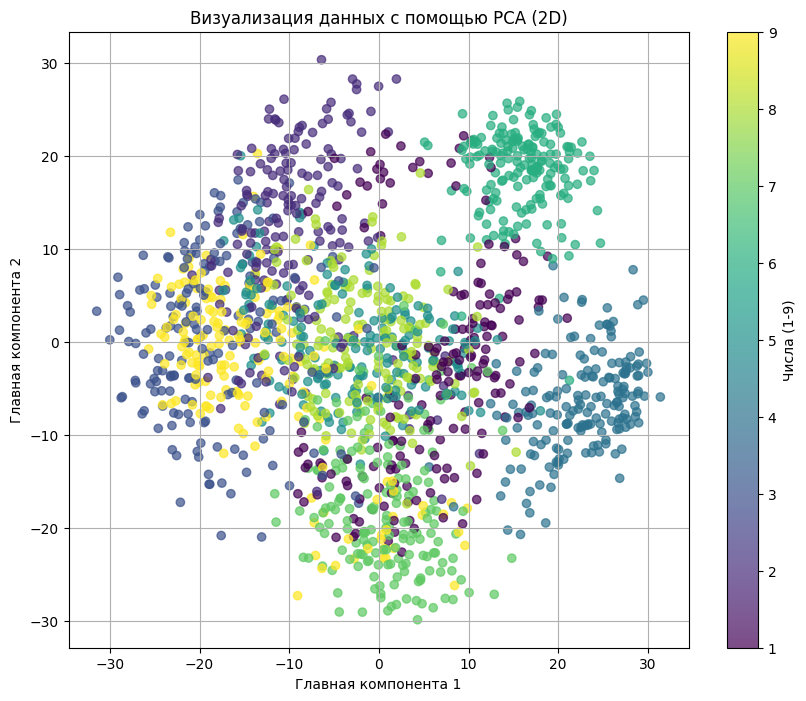

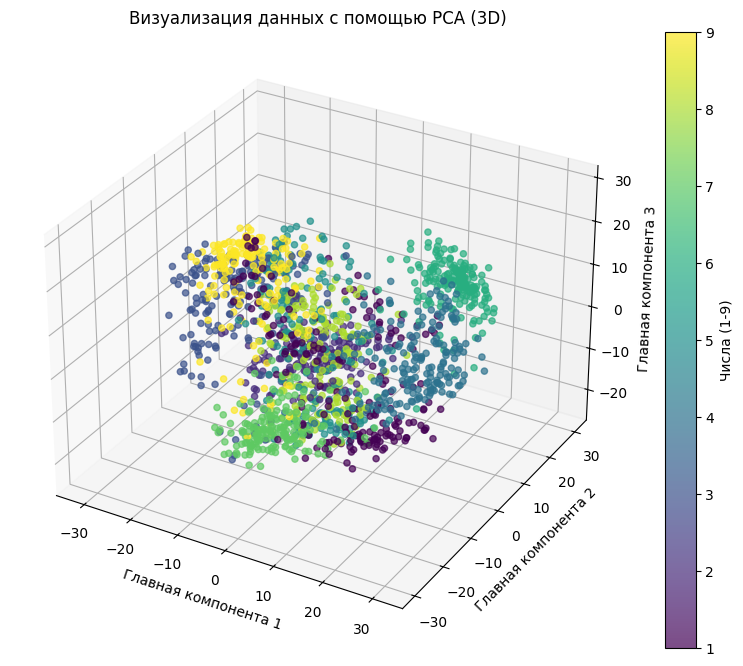

Точность классификации с PCA (2D): 0.5833
Точность классификации с PCA (3D): 0.7037


In [35]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# PCA: 2D
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=y, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Числа (1-9)')
plt.title("Визуализация данных с помощью PCA (2D)")
plt.xlabel("Главная компонента 1")
plt.ylabel("Главная компонента 2")
plt.grid(True)
plt.show()

# PCA: 3D
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], c=y, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Числа (1-9)')
ax.set_title("Визуализация данных с помощью PCA (3D)")
ax.set_xlabel("Главная компонента 1")
ax.set_ylabel("Главная компонента 2")
ax.set_zlabel("Главная компонента 3")
plt.show()

# Классификация на основе PCA (2D)
X_train_2d, X_test_2d, y_train, y_test = train_test_split(X_pca_2d, y, test_size=0.2, random_state=42)
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_2d, y_train)
y_pred_2d = clf.predict(X_test_2d)
accuracy_pca_2d = accuracy_score(y_test, y_pred_2d)
print(f"Точность классификации с PCA (2D): {accuracy_pca_2d:.4f}")

# Классификация на основе PCA (3D)
X_train_3d, X_test_3d = train_test_split(X_pca_3d, test_size=0.2, random_state=42)
clf.fit(X_train_3d, y_train)
y_pred_3d = clf.predict(X_test_3d)
accuracy_pca_3d = accuracy_score(y_test, y_pred_3d)
print(f"Точность классификации с PCA (3D): {accuracy_pca_3d:.4f}")


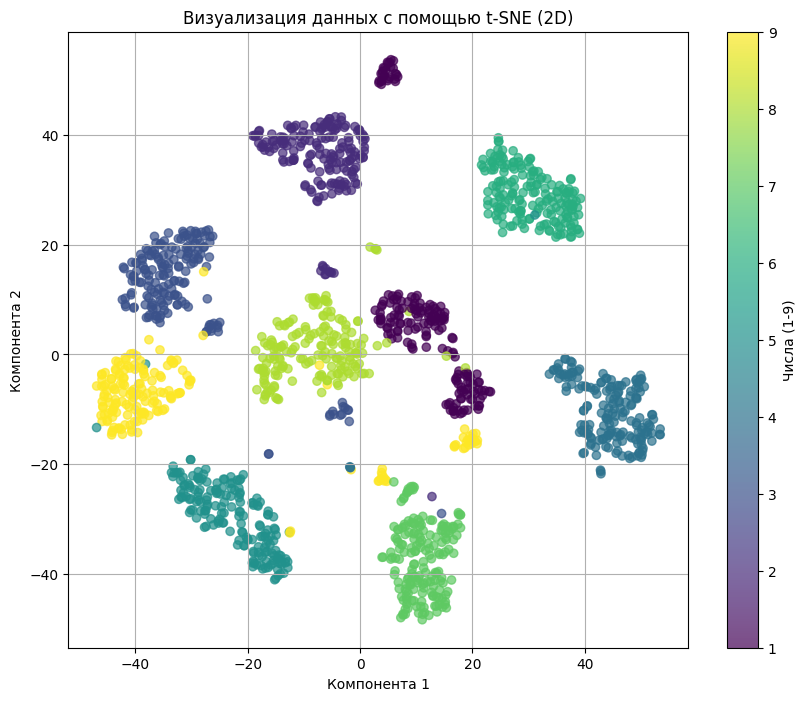

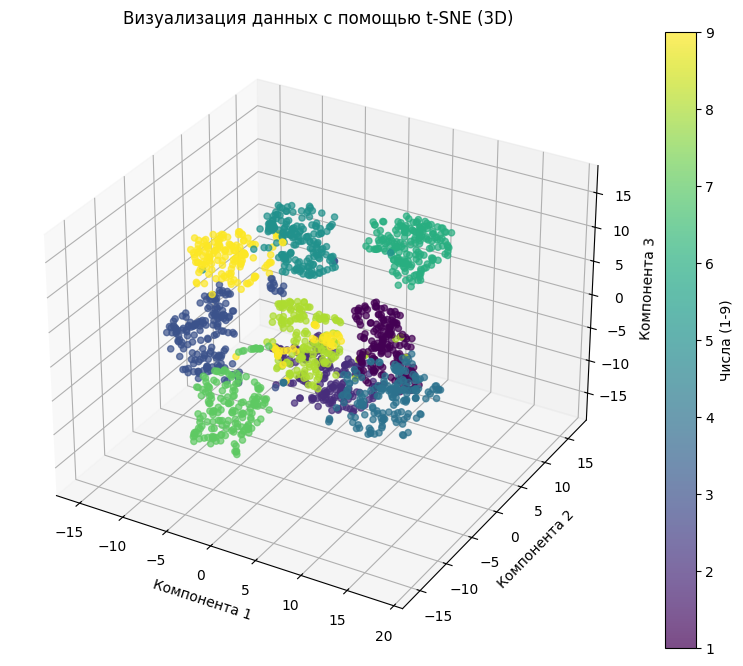

Точность классификации с t-SNE (2D): 0.9938
Точность классификации с t-SNE (3D): 0.9938


In [36]:
from sklearn.manifold import TSNE

# t-SNE: 2D
tsne_2d = TSNE(n_components=2, random_state=42)
X_tsne_2d = tsne_2d.fit_transform(X)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tsne_2d[:, 0], X_tsne_2d[:, 1], c=y, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Числа (1-9)')
plt.title("Визуализация данных с помощью t-SNE (2D)")
plt.xlabel("Компонента 1")
plt.ylabel("Компонента 2")
plt.grid(True)
plt.show()

# t-SNE: 3D
tsne_3d = TSNE(n_components=3, random_state=42)
X_tsne_3d = tsne_3d.fit_transform(X)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_tsne_3d[:, 0], X_tsne_3d[:, 1], X_tsne_3d[:, 2], c=y, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Числа (1-9)')
ax.set_title("Визуализация данных с помощью t-SNE (3D)")
ax.set_xlabel("Компонента 1")
ax.set_ylabel("Компонента 2")
ax.set_zlabel("Компонента 3")
plt.show()

# Классификация на основе t-SNE (2D)
X_train_tsne_2d, X_test_tsne_2d = train_test_split(X_tsne_2d, test_size=0.2, random_state=42)
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_tsne_2d, y_train)
y_pred_tsne_2d = clf.predict(X_test_tsne_2d)
accuracy_tsne_2d = accuracy_score(y_test, y_pred_tsne_2d)
print(f"Точность классификации с t-SNE (2D): {accuracy_tsne_2d:.4f}")

# Классификация на основе t-SNE (3D)
X_train_tsne_3d, X_test_tsne_3d = train_test_split(X_tsne_3d, test_size=0.2, random_state=42)
clf.fit(X_train_tsne_3d, y_train)
y_pred_tsne_3d = clf.predict(X_test_tsne_3d)
accuracy_tsne_3d = accuracy_score(y_test, y_pred_tsne_3d)
print(f"Точность классификации с t-SNE (3D): {accuracy_tsne_3d:.4f}")


### Поиск лучших параметров GridSearch и RandomSearch

In [37]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
import numpy as np

# Определение параметров для поиска
param_grid_regression = {
    'regressor__alpha': [0.1, 1.0, 10.0]  # Параметры регуляризации для Ridge
}

param_random_regression = {
    'regressor__alpha': np.linspace(0.1, 10, 100)  # Диапазон для случайного поиска
}

# Пайплайн для регрессии
regression_pipeline = Pipeline([
    ('preprocessor', preprocessor_regression),
    ('regressor', Ridge())
], verbose=True)

# GridSearchCV для регрессии
grid_search_reg = GridSearchCV(regression_pipeline, param_grid=param_grid_regression, cv=5, scoring='neg_mean_squared_error', verbose=1)
grid_search_reg.fit(X_train_reg, y_train_reg)
print("\nЛучшие параметры (GridSearch) для регрессии:", grid_search_reg.best_params_)
print("Лучший MSE (GridSearch):", -grid_search_reg.best_score_)

# RandomizedSearchCV для регрессии
random_search_reg = RandomizedSearchCV(regression_pipeline, param_distributions=param_random_regression, n_iter=10, cv=5, scoring='neg_mean_squared_error', verbose=1, random_state=42)
random_search_reg.fit(X_train_reg, y_train_reg)
print("\nЛучшие параметры (RandomSearch) для регрессии:", random_search_reg.best_params_)
print("Лучший MSE (RandomSearch):", -random_search_reg.best_score_)


Fitting 5 folds for each of 3 candidates, totalling 15 fits
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   0.0s
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   0.0s
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   0.0s
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransforme

In [38]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline

# Определение параметров для поиска
param_grid_classification = {
    'classifier__max_depth': [5, 10, 15],
    'classifier__min_samples_split': [2, 5, 10]
}

param_random_classification = {
    'classifier__max_depth': np.arange(1, 20),
    'classifier__min_samples_split': np.arange(2, 20)
}

# Пайплайн для классификации
classification_pipeline = Pipeline([
    ('preprocessor', preprocessor_classification),
    ('classifier', DecisionTreeClassifier(random_state=42))
], verbose=True)

# GridSearchCV для классификации
grid_search_clf = GridSearchCV(classification_pipeline, param_grid=param_grid_classification, cv=5, scoring='accuracy', verbose=1)
grid_search_clf.fit(X_train_clf, y_train_clf)
print("\nЛучшие параметры (GridSearch) для классификации:", grid_search_clf.best_params_)
print("Лучшая точность (GridSearch):", grid_search_clf.best_score_)

# RandomizedSearchCV для классификации
random_search_clf = RandomizedSearchCV(classification_pipeline, param_distributions=param_random_classification, n_iter=10, cv=5, scoring='accuracy', verbose=1, random_state=42)
random_search_clf.fit(X_train_clf, y_train_clf)
print("\nЛучшие параметры (RandomSearch) для классификации:", random_search_clf.best_params_)
print("Лучшая точность (RandomSearch):", random_search_clf.best_score_)


Fitting 5 folds for each of 9 candidates, totalling 45 fits
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.0s
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.0s
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.0s
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransforme

In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score

df = pd.read_csv('/content/heart.csv')

# Загрузка данных (предполагаем, что df уже загружен)
# Преобразование качества в бинарный признак
df['risk_group'] = (df['IHD_DX'].astype(int) <=5).astype(int)

# Удаляем `quality` из данных
X = df.drop(columns=['IHD_DX', 'risk_group'])
y = df['risk_group']

# Разделение признаков на числовые и категориальные
numeric_features = X.select_dtypes(include=['float64', 'int64']).columns
categorical_features = X.select_dtypes(include=['category']).columns

# Разделение данных на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Преобразование числовых данных
scaler = StandardScaler()
X_train_numeric = scaler.fit_transform(X_train[numeric_features])
X_test_numeric = scaler.transform(X_test[numeric_features])

# Преобразование категориальных данных
encoder = OneHotEncoder()
X_train_categorical = encoder.fit_transform(X_train[categorical_features]).toarray()
X_test_categorical = encoder.transform(X_test[categorical_features]).toarray()

# Объединение преобразованных данных
import numpy as np
X_train_transformed = np.hstack([X_train_numeric, X_train_categorical])
X_test_transformed = np.hstack([X_test_numeric, X_test_categorical])

# Определение параметров для RandomizedSearchCV
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Обучение RandomForestClassifier с RandomizedSearchCV
rf = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    scoring='accuracy',
    random_state=42,
    verbose=1
)

random_search.fit(X_train_transformed, y_train)

# Лучшие параметры и точность
best_params = random_search.best_params_
best_score = random_search.best_score_

# Тестирование на отложенной выборке
y_pred = random_search.best_estimator_.predict(X_test_transformed)
test_accuracy = accuracy_score(y_test, y_pred)

print("\nЛучшие параметры:", best_params)
print(f"Лучшая точность на кросс-валидации: {best_score:.4f}")
print(f"Точность на тестовой выборке: {test_accuracy:.4f}")


Fitting 5 folds for each of 20 candidates, totalling 100 fits

Лучшие параметры: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': None, 'bootstrap': False}
Лучшая точность на кросс-валидации: 0.8562
Точность на тестовой выборке: 0.9000
